In [303]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 
import theano
from theano import shared, tensor as tt

sns.set_style('ticks')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

plt.rc('font', **font)



# Sum of Squares

In [304]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)


def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5

    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma

    return floatX(tau), floatX(sigma)


class Sum_of_Squares(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [305]:
# Data
cwd = os.chdir("/Users/ArgonLab/Documents")
df1 = pd.read_csv("Kula_Mix_Mica.csv", engine = "python")

In [306]:
df1.head()

,temp1,time1,ar391,ar401,age1,age_err1,temp2,time2,ar392,ar402,age2,age_err2,temp3,time3,ar393,ar403,age3,age_err3
0,725,12,92.06,6137.52,121.86,0.75,725,12,104.06,6223.25,108.19,0.66,725.0,12.0,109.82,5575.05,90.79,0.63
1,775,12,74.49,3128.33,131.81,0.61,775,12,101.34,3596.88,112.79,0.50,775.0,12.0,98.11,2988.19,92.66,0.52
2,820,12,185.53,7118.49,129.69,0.58,820,12,199.84,6747.15,111.24,0.49,820.0,12.0,212.02,6018.54,91.57,0.50
3,850,12,327.39,11860.89,127.00,0.57,840,12,222.71,6878.87,107.21,0.46,850.0,12.0,340.72,8783.32,90.59,0.49
4,875,12,487.57,18061.60,131.10,0.58,860,12,326.00,10333.14,111.16,0.48,875.0,12.0,493.39,13065.36,94.46,0.51


In [307]:
temp1 = df1['temp2'].values
time1 = df1['time2'].values
a391 = df1['ar392'].values
a401 = df1['ar402'].values
age1 = df1['age2'].values
age1_err = df1['age_err2'].values

In [308]:
# Shared variable for modelling 

data = age1
err = age1_err

age_err = shared(err*5)

In [309]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [310]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [311]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [312]:
x = 100 *frel_data(a391)

# The Age Spectra and Fractional Release Curves

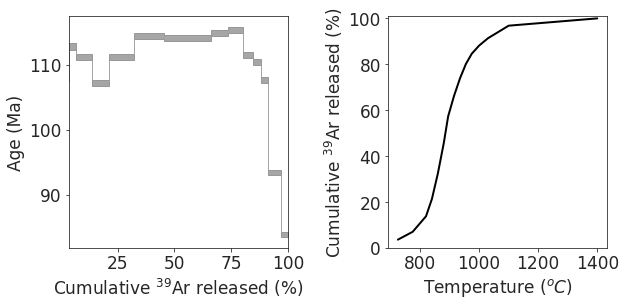

In [313]:
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(x, data - err, data + err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(x.min(), x.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [314]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3

(array([9.737e+03, 1.840e+02, 5.200e+01, 1.300e+01, 9.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.46273470e-03, 5.67551557e+00, 1.13495684e+01, 1.70236213e+01,
        2.26976741e+01, 2.83717269e+01, 3.40457798e+01, 3.97198326e+01,
        4.53938854e+01, 5.10679383e+01, 5.67419911e+01]),
 <a list of 10 Patch objects>)

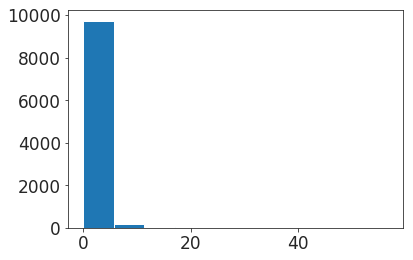

In [315]:
z = np.random.lognormal(-1, 1.4, 10000)
plt.hist(z)


In [316]:
BAr = pm.Model()
M = 1
with BAr: 
    # Volume Fraction 
    phi = pm.Dirichlet('phi', a = np.array([0.5, 0.5]), 
                      shape = 2, 
                      testval = (0.5, 0.5))
    
    phi_min = pm.Potential('phi_min', 
                          tt.switch(phi[0] < 0.4, 
                                    -np.inf,
                                   0)+ 
                          tt.switch(phi[0] > 0.6, 
                                   -np.inf,
                                   0))
    

    # Diffusion Kinetics 
    # Mineral 
    ea1 = pm.Normal('ea1', mu = 260, sd = 10)
    ea2 = pm.Normal('ea2', mu = 260, sd = 10)
    
    
    d01 = pm.TruncatedNormal('d01', mu = 2, sd = 20,
                             lower = 0.0)

    
    d02 = pm.TruncatedNormal('d02', mu = 2, sd = 20,
                             lower = 0.0)
    
    
    
    a1 = pm.Uniform('a1', lower = 0.0177/2, upper = 0.0125)
    
    a2 = pm.Uniform('a2', lower = 0.0177/2, upper = 0.0125)

    

In [317]:
with BAr: 
  # Deterministic
    # Cumulative Release 
    c1 = fracrelx(ea1,d01, a1, tempk, t_obs)

    c2 = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    m1 = phi[0]
    
    m2 = phi[1]
    
    # Cumulative Release Model 
    
    model1 = m1*c1 + m2*c2
    
#Monotonicity
    
####################################################################################################
    for i in range(len(tempk) - 1): 
        Frel_bound_a = pm.Potential(f'f_bound_a{i}', 
                                 tt.switch(c1[i +1] - c1[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_b = pm.Potential(f'f_bound_b{i}', 
                                 tt.switch(c2[i +1] - c2[i] < 0, 
                                          -np.inf, 0)) 

        
        
    for i in range(len(data) - 1): 
        f_con_mu = pm.Potential(f'f_bound_mu{i}', 
                               tt.switch(model1[i + 1] - model1[i] < 0, 
                                        -np.inf, 0))  
########################################################################################################
     
    

In [318]:
with BAr: 
    
    # Incremental Curves 
    i1 = Increment(ea1, d01, a1, tempk, t_obs)
    i2 = Increment(ea2, d02, a2, tempk, t_obs)
    
    
    # Mixture Parameter
    
    phi1 = pm.Deterministic('phi1', (m1*i1)/(m1*i1 + m2*i2))
    
    phi2 = pm.Deterministic('phi2',(m2*i2)/(m1*i1 + m2*i2)) 


In [319]:
with BAr: 
    # Ages 
    age1 = pm.Uniform('age1', lower = 0.0, 
                      upper = 4600, 
                      testval = 200)
    age2 = pm.Uniform('age2', lower = 0.0, 
                      upper = 4600, 
                      testval = 100)
    
    # order potential 
    order_cons = pm.Potential('order', 
                             tt.switch(age1 - age2 < 0, 
                                      -np.inf,  0))



In [320]:
with BAr: 
    # Age Spectra Model 
    
    model2 = (phi1*age1) + (phi2*age2)

In [321]:
# Models for plotting 

with BAr: 
    f_model = pm.Deterministic('f_model', 
                               model1)
    age_model = pm.Deterministic('Age_Model', 
                                model2)

In [322]:
with BAr: 
    # Cumulative Release Error 
    f_err = pm.HalfNormal('f_err', sd = 0.01)
    
    # Age Error 
    age_err_model = pm.HalfNormal('age_err_model', 
                                  sd = 5, 
                                 shape = N)

In [323]:
def logp(mod, data, err): 
    logp = -tt.sqr(data - mod)/(2 * err * err)
    return logp.sum()

In [324]:
with BAr: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = model1, sd = f_err, 
                 observed = data_f)
    


In [325]:
with BAr: 
    # Age Spectra Likelihood 

    L2 = Sum_of_Squares('L2', mu = model2, 
                   sd = age_err_model, 
                   observed = data)
                   

In [326]:
BAr.check_test_point()

phi_stickbreaking__       -1.84
ea1                       -3.22
ea2                       -3.22
d01_lowerbound__          -3.30
d02_lowerbound__          -3.30
a1_interval__             -1.39
a2_interval__             -1.39
age1_interval__           -3.18
age2_interval__           -3.85
f_err_log__               -0.77
age_err_model_log__      -11.55
L1                    -41129.13
L2                      -837.42
Name: Log-probability of test_point, dtype: float64

In [327]:
SAMPLES = 100000
BURN = 100000


with BAr: 
    
    trace = pm.sample(SAMPLES, tune = BURN, 
                      step = pm.Metropolis(), 
                     chains = 2, 
                     cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age_err_model]
>Metropolis: [f_err]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 2 chains: 100%|██████████| 400000/400000 [31:56<00:00, 208.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


# Traceplot

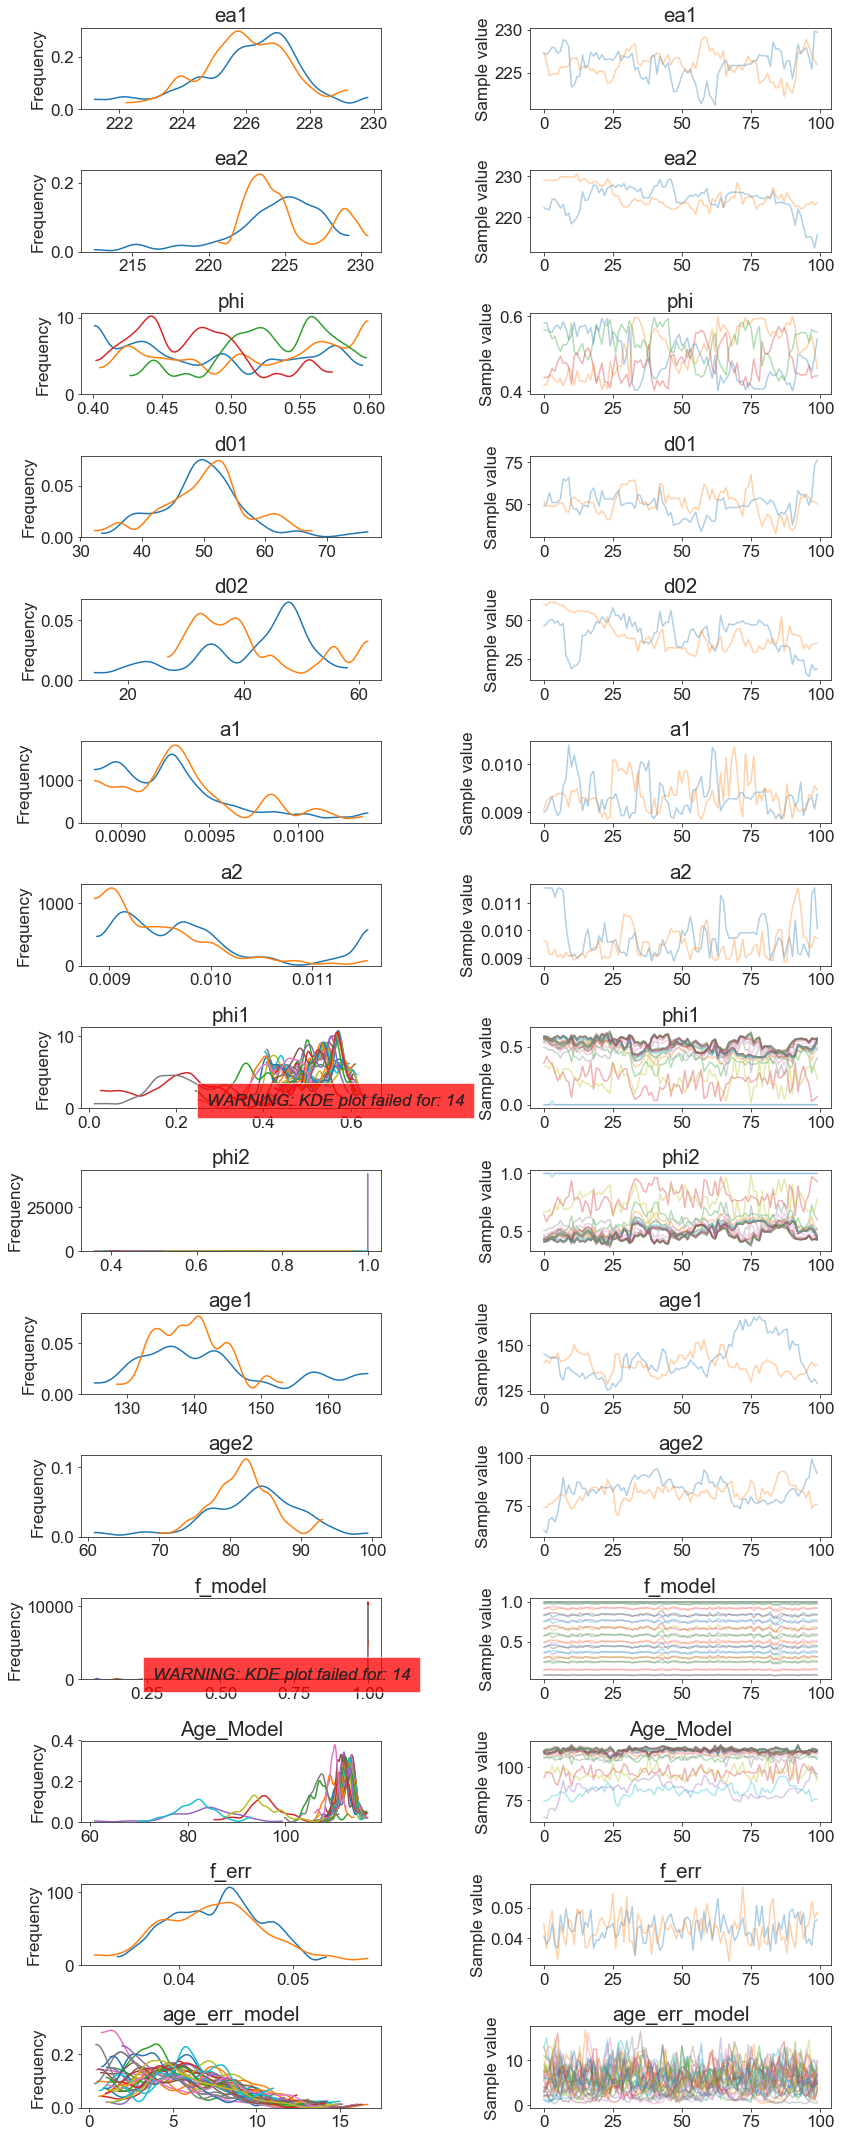

In [328]:
sns.set_style('ticks')
pm.traceplot(trace[-1000::10]); 

In [329]:
print(trace['age1'][-10000:].mean(axis = 0))
print(trace['age2'][-10000:].mean(axis = 0))
print(2*np.std(trace['age1'][-10000:]))
print(2*np.std(trace['age2'][-10000:]))

142.63361441703148
82.4442211307277
23.487544459269404
12.575128494511153


# 95% Credible Interval 

# Mean Predictive Models
* Plot these to check the mean posterior and the deviation from data

In [330]:
with BAr: 
    ppc = pm.sample_ppc(trace[-10000:], 5000)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 5000/5000 [00:41<00:00, 120.86it/s]


In [349]:
low1, high1 = np.percentile(ppc['L1'], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(ppc['L2'], [2.5, 97.5], axis = 0)

Z1 = ppc['L1'].mean(axis = 0)
Z2 = ppc['L2'].mean(axis = 0)

# Fractional release plot

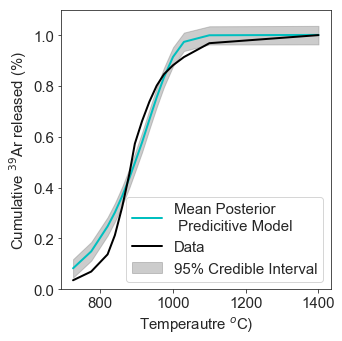

In [350]:

plt.figure(figsize = (5,5))
plt.fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.ylim(0, 1.1)
plt.tight_layout()

# Age Spectra plot

In [354]:
# Plotting age spectra parameters

Z1_plot = np.insert(Z1, 0,0 )
Z2_plot = np.insert(Z2, 0,Z2[0])
low2_plot = np.insert(low2,0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])

x_data_plot = np.insert(data_f, 0, 0)
data_plot = np.insert(data, 0, data[0])
data_err_plot = np.insert(err, 0, err[0])

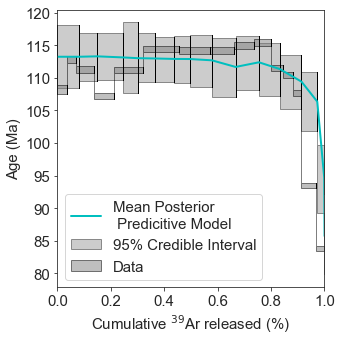

In [355]:
plt.figure(figsize = (5,5))
plt.fill_between(Z1_plot, low2_plot, high2_plot, alpha = 0.4, 
                facecolor = 'grey', 
                edgecolor = 'k',
                 label = '95% Credible Interval', 
                step = 'pre')
plt.plot(Z1_plot, Z2_plot, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(x_data_plot, data_plot - data_err_plot, data_plot + data_err_plot, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

for i in range(len(Z1_plot)): 
    plt.vlines(Z1_plot, low2_plot, high2_plot, 
              color = 'k', 
              lw = 0.8)
    plt.vlines(x_data_plot, data_plot - data_err_plot, data_plot + data_err_plot,
              color = 'k', 
              lw = 0.8)

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.xlim(0, 1)
plt.tight_layout()

# Combined

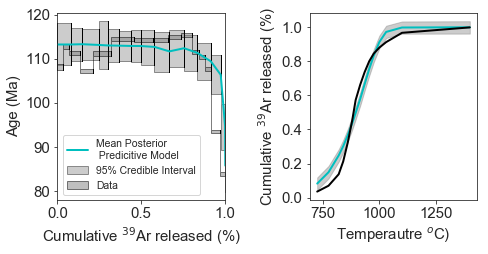

In [357]:
## AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1_plot, low2_plot, high2_plot, alpha = 0.4, 
                facecolor = 'grey', 
                edgecolor = 'k',
                 label = '95% Credible Interval', 
                step = 'pre')
ax[0].plot(Z1_plot, Z2_plot, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(x_data_plot, data_plot - data_err_plot, data_plot + data_err_plot, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

for i in range(len(Z1_plot)): 
    ax[0].vlines(Z1_plot, low2_plot, high2_plot, 
              color = 'k', 
              lw = 0.8)
    ax[0].vlines(x_data_plot, data_plot - data_err_plot, data_plot + data_err_plot,
              color = 'k', 
              lw = 0.8)

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best', 
            fontsize = 'x-small')
ax[0].set_xlim(0, 1)

# Fractional Release
ax[1].fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

In [353]:
print(trace['age1'][-50000:].mean(axis = 0))
print(trace['age2'][-50000:].mean(axis = 0))

print(2*np.std(trace['age1'][-50000:]))
print(2*np.std(trace['age2'][-50000:]))



140.45598581155136
84.39238806535768
20.00650091069206
13.658573368046527


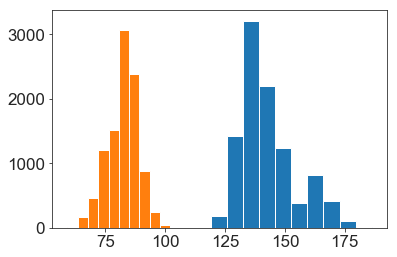

In [336]:
plt.hist(trace['age1'][-10000:].flatten()); 
plt.hist(trace['age2'][-10000:].flatten()); 

##### Log Likelihood of each Drawn Sample
* Calculation of logp for each draw in trace
* Cell below

# ml = BAr.logp
logp = [ml(i) for i in trace]

# Log Likelihood and Age trace from paper

# Save to DataFrames for plotting

In [337]:
df = pd.DataFrame({"age_model": Z2, 
                  "age_model_low": low2, 
                  "age_model_high": high2, 
                  "frel_model": Z1, 
                  "frel_model_low": low1, 
                  "frel_model_high": high1, 
                  "age_data": data, 
                  "age_err": age1_err, 
                   "frel_data": data_f, 
                  "temp": temp1})

# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace[-10000::2])

In [338]:
df.to_csv('kula2_muscovite_posterior.csv')

In [339]:
df1.to_csv('kula2_muscovite_trace.csv')

In [340]:
dfp = pd.DataFrame({"age1":df1['age1'].values, 
                   "age2": df1['age2'].values, 
                    "d01":df1['d01'].values, 
                   "d02":df1['d02'].values,
                   "ea1":df1['ea1'].values, 
                   "ea2":df1['ea2'].values})

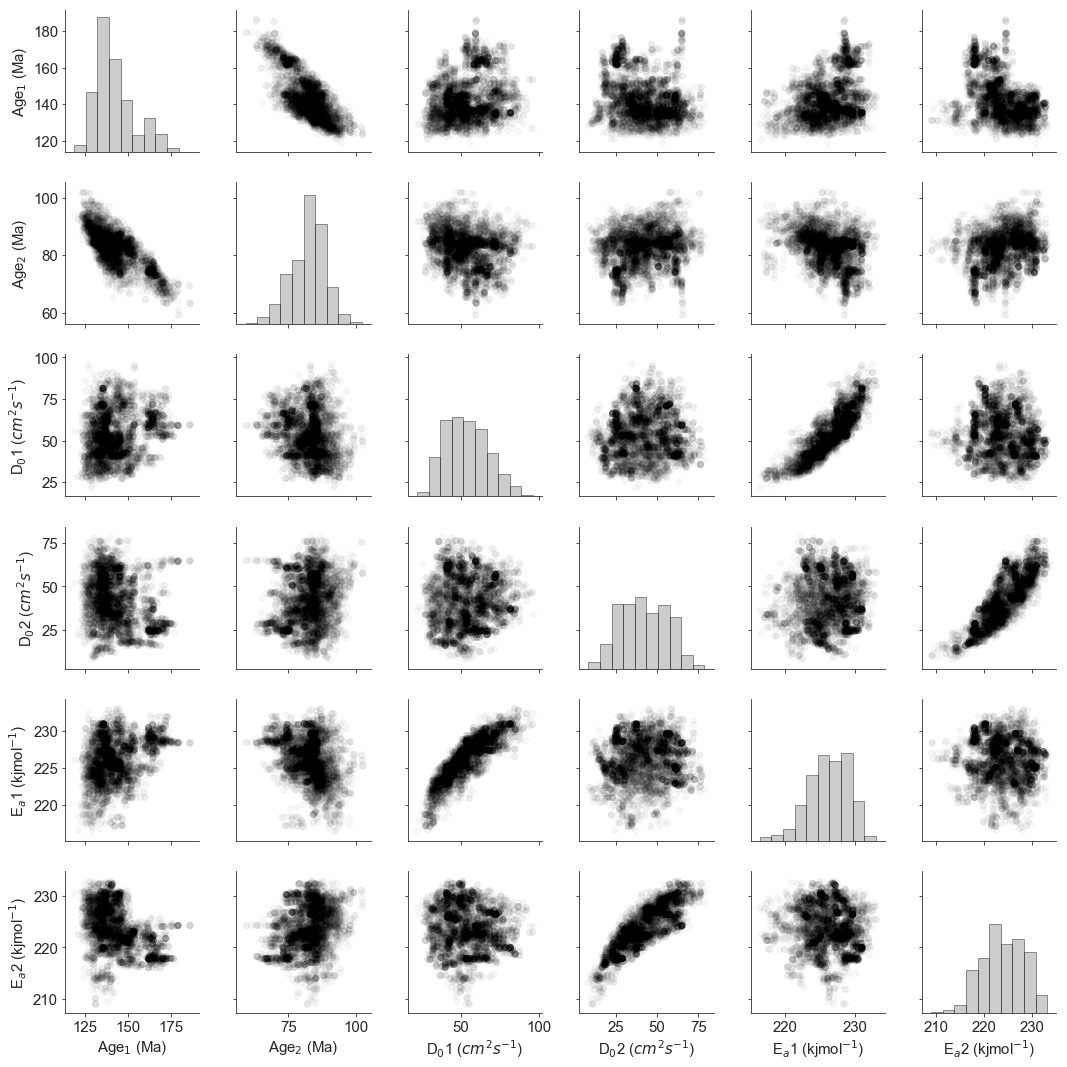

In [341]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)


g = sns.PairGrid(dfp[-5000:])
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.4)
g = g.map_offdiag(plt.scatter, alpha = 0.03, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kjmol$^{-1}$)');

In [342]:
dfx = dfp[-5000::4]

dfx.to_csv('kula2muscovite_final.csv')